In [142]:
using PyPlot
using Base

In [205]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 5. .* ones(size(t)); # emissions scenario
q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
q[81:end] .= 0.
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 1.; # damage parameter (trillion dolars / C^2)
D_0 = β .* δT_0.^2; # baseline damages
γ = 0. #1. /30. # discount rate
ρ = 0.03
GWP = 100. # Global World Product (10^12 $/yr)
C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
C_λ = 10. *GWP; # geoengineering (10^12 $/yr)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions

# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t)*1.;
φ = nondim_linear(t)/3.;
λ = nondim_linear(t)*0.;
χ = nondim_linear(t)/10.;

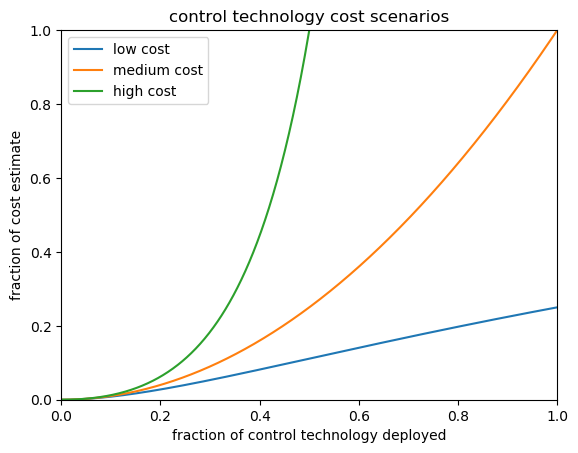

PyObject <matplotlib.legend.Legend object at 0x151a2f278>

In [206]:
x = Array(0:0.001:1.)

y_low = (x./(1. .+x)).^2
y_med = x.^2
y_high = (x./(1. .-x)).^2
title("control technology cost scenarios")
plot(x,f_low(x), label="low cost")
plot(x,f_med(x), label="medium cost")
plot(x,f_high(x), label="high cost")
xlim([0,1])
ylim([0,1])
ylabel("fraction of cost estimate")
xlabel("fraction of control technology deployed")
legend()

In [207]:
c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_med(λ) .+ C_ϕ.*f_med(ϕ) .+ C_φ.*f_med(φ) .+ C_χ.*f_med(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
    200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

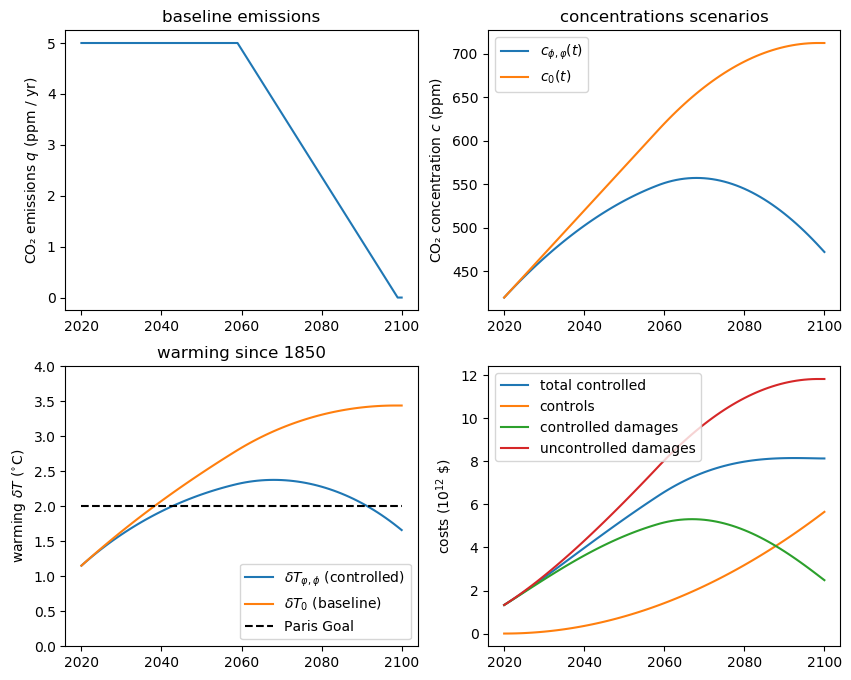

PyObject <matplotlib.legend.Legend object at 0x151e341d0>

In [208]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()

## Gradient descent cost minimization

In [209]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-5
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

In [210]:
count = 1
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    ∇ = ∇T(ϕ, φ, χ, λ)
    norm = 0.
    for ∂T∂α = ∇
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 2.e-4
    ϕ .-= ∇[1].*Δs
    φ .-= ∇[2].*Δs
    χ .-= ∇[3].*Δs
    λ .-= ∇[4].*Δs
    count+=1
    
    if count>1000
        break
    end
end

1468.3020076345174 1188.7445797685064 1018.4188712948892 908.5939214293893 834.0909242007829 781.1987241849272 742.0948222790505 712.1236967780986 688.4063345707464 669.0996274353115 652.9864411802514 639.2404057505789 627.286352586147 616.7150022732243 607.2292526874974 598.6095422608587 590.6909495880675 583.3477634225978 576.4828438581968 570.0201998360699 563.8996856455819 558.0731860357895 552.5018315222084 547.153906237742 542.0033207506658 537.0284208148212 532.2110911341189 527.5360719832354 522.9904064155207 518.5630174220263 514.2443790939371 510.0262430749151 505.90142622314926 501.8636409030924 497.9073418116239 494.0276281845167 490.2201338447673 486.4809588220666 482.80660022715426 479.19389431190194 475.6399855441246 472.14226640940905 468.69836302532167 465.3060985767318 461.963475960872 458.6686480642739 455.41991023273107 452.21567876449484 449.0544857126073 445.93495298587595 442.8557995238086 439.81582220428777 436.81388870666564 433.8489395828447 430.91996703057947

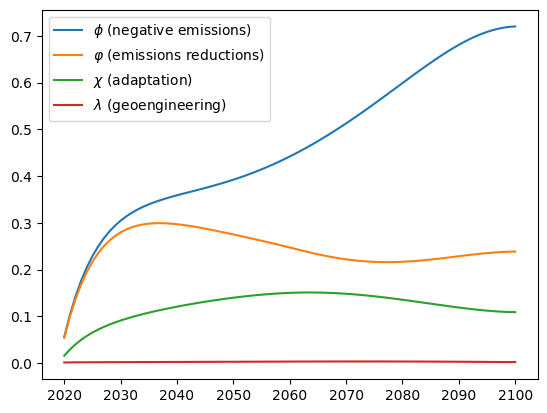

PyObject <matplotlib.legend.Legend object at 0x1521a1940>

In [211]:
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
legend()

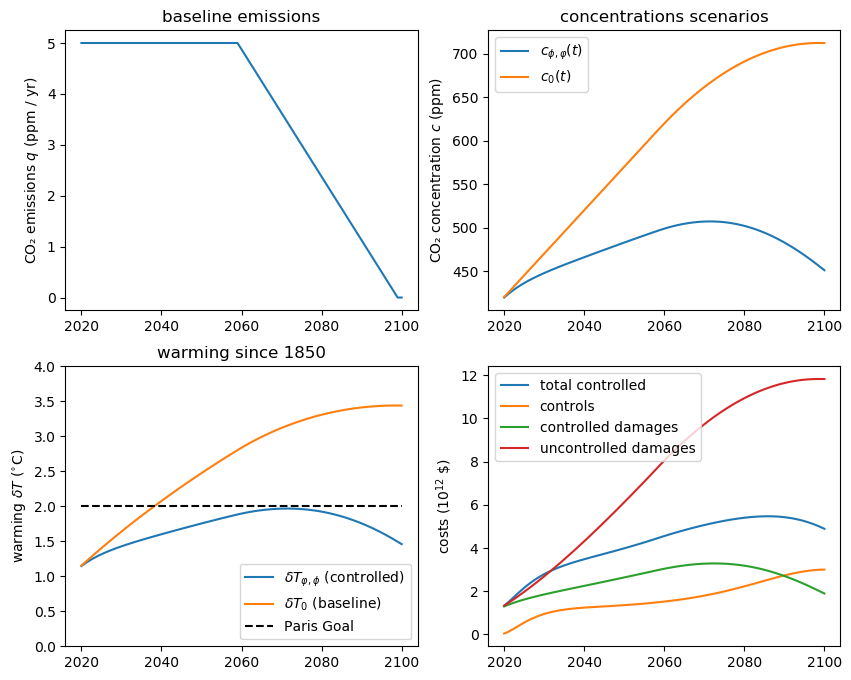

PyObject <matplotlib.legend.Legend object at 0x152bb5320>

In [213]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()